In [1]:
# 因本機使用 TensorFlow 2.2.0 版本，故於colab上訓練模型時須使用此版本，方能於本機讀取model
! pip3 uninstall -y tensorflow
! pip3 install scikit-plot tensorflow==2.2.0
! pip3 show tqdm numpy opencv-python scikit-learn scikit-plot

In [2]:
! unzip THSR_captcha_12000.zip
! rm -rf sample_data logs ckpt_file saved_model *.png *.zip # 清空上一次生成的檔案

# show GPU information 

In [3]:
! nvidia-smi

Mon Mar 29 18:06:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Tensorboard in Colab [reference](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb#scrollTo=lpUO9HqUKP6z)

In [4]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# import required packages and check GPU setting

In [5]:
%tensorflow_version 2.x
import cv2
import tqdm
import datetime
import tensorflow as tf
from os import listdir, path
from IPython.display import Image
from scipy.special import softmax
from matplotlib import pyplot as plt
from argparse import ArgumentParser, Namespace
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scikitplot.metrics import plot_confusion_matrix as plot_cm
from numpy import eye, newaxis, concatenate, ndarray, array, where, column_stack, split, argmax
from typing import List, Tuple

# 檢測在colab中是否設定有GPU運算單元
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
def parse_args() -> Namespace:
    parser = ArgumentParser('Hyper-parameters setting')
    parser.add_argument('--epochs', type=int, default=100, help='epochs')
    parser.add_argument('--batch_size', type=int, default=32, help='batch size in training step')
    parser.add_argument('--test_size', type=float, default=0.2, help='parameter in train_test_split')
    parser.add_argument('--validation_rate', type=float, default=0.1, help='training set split into train & validate')
    parser.add_argument('--dataset_path', type=str, default='/content/THSR_captcha/', help='dataset path')
    return parser.parse_args(args=[])


class AllDigitsAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='all_digits_acc', **kwargs):
        super(AllDigitsAccuracy, self).__init__(name=name, **kwargs)
        self.ad_acc = self.add_weight(name='adacc', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # from one-hot encoding to sparse classes type (tensor: 3d ---> 2d)
        y_true_ = tf.argmax(y_true, axis=2)

        # because model output didn't pass softmax operation
        y_pred_ = tf.keras.activations.softmax(y_pred)

        # y_pred_ becomes sparse classes type(tensor: 3d ---> 2d)
        y_pred_ = tf.argmax(y_pred_, axis=2)

        # compare y_true_ and y_pred_, output is tf.bool(tensor: 2d ---> 2d)
        v = y_true_ == y_pred_

        # check whether every digit is correct (tensor: 2d ---> 1d)
        v = tf.reduce_all(v, axis=1)

        # cast to float for next progress to compute reduce_mean
        v = tf.cast(v, dtype=tf.dtypes.float32)
        # if sample_weight is not None:
        #     sample_weight = tf.cast(sample_weight, self.dtype)
        #     sample_weight = tf.broadcast_to(sample_weight, values.shape)
        #     values = tf.multiply(values, sample_weight)
        self.ad_acc.assign_add(tf.reduce_sum(v))

    def result(self):
        return self.ad_acc

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.ad_acc.assign(0.0)


class Utility(object):
    def __init__(self):
        self.d = {'2': 0, '3': 1, '4': 2, '5': 3, '7': 4, '9': 5, 'A': 6, 'C': 7, 'F': 8, 'H': 9,
              'K': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'T': 16, 'Y': 17, 'Z': 18}
        self.d_ = {i_value: i_key for i_key, i_value in self.d.items()}

    def split_digit_label(self, label_list: List[str]) -> Tuple:
        """:param label_list is like ['ZPAH', '2K9T', ...]
            only use by plot_label_distribution()"""
        string_d1, string_d2, string_d3, string_d4 = '', '', '', ''
        for i_label in label_list:
            string_d1 += i_label[0]
            string_d2 += i_label[1]
            string_d3 += i_label[2]
            string_d4 += i_label[3]
        return string_d1, string_d2, string_d3, string_d4

    def plot_label_distribution(self, label_list: List[str]) -> plt.Figure:
        """:param label_list is like ['4HMQ', 'MR4Y', ...]"""
        d_keys = self.d.keys()
        dd = self.split_digit_label(label_list)
        y_pos = [jj for jj in range(len(d_keys))]
        fig_ = plt.figure(figsize=(24, 16), dpi=500)
        for i_bar in range(4):
            plt.subplot(2, 2, i_bar + 1)
            plt.title('digit' + str(i_bar + 1) + ' label distionbution', fontsize=20)
            plt.bar(y_pos, [dd[i_bar].count(j) for j in d_keys], align='center', alpha=0.5)
            plt.xticks(y_pos, d_keys, fontsize=18)
            plt.yticks(fontsize=18)
            plt.xlabel('label', fontsize=18)
            plt.ylabel('frequency', fontsize=18)
            plt.grid(axis='y', linestyle='-', linewidth=1)
        return fig_

    def convert2onehot(self, label: str) -> ndarray:
        """:param label is like '4HMQ'、'MR4Y'、..."""
        l = [self.d[i] for i in label]
        result = eye(max(self.d.values()) + 1)[l]
        return result[newaxis, :]

    def remove_curve(self, img_arr: ndarray) -> ndarray:
        """:param img_arr is np.ndarray to represent a picture."""
        res = img_arr.copy()
        height, width = res.shape
        img_arr[:, 5: width - 5] = 0
        image_idx = where(img_arr == 255)
        xx, yy = array([image_idx[1]]), height - image_idx[0]
        poly_reg, l_reg = PolynomialFeatures(degree=2), LinearRegression(n_jobs=-1)
        xx_poly = poly_reg.fit_transform(xx.T)
        l_reg.fit(xx_poly, yy)
        xx2 = array([[i for i in range(width)]])
        xx2_poly = poly_reg.fit_transform(xx2.T)
        for ele in column_stack([l_reg.predict(xx2_poly).round(0), xx2[0]]):
            # print(ele)
            loc = height - int(ele[0])
            # if newimg[loc - 4 :loc + 4, int(ele[1])] == 255:
            # newimg[loc - 3: loc + 3, int(ele[1])] = 0  # this line can remove curve。
            res[loc - 3: loc + 3, int(ele[1])] = 255 - res[loc - 3: loc + 3, int(ele[1])]  # 弧線過處，黑白互換。
        return res

    def load_data(self, data_path: str) -> Tuple:
        name_list = [name[:4] for name in listdir(data_path)]
        data_sample, data_label = [], []
        for n in name_list:
            data_sample.append(cv2.imread(data_path + n + '.jpg'))
            data_label.append(self.convert2onehot(label=n))
        data_label = concatenate(data_label, axis=0)
        return data_sample, data_label

    def data_preprocessing(self, arr_list: List[ndarray], label: ndarray, test_size: float = 0.2) -> Tuple:
        with tqdm.trange(len(arr_list)) as t:
            for idx in t:
                temp = cv2.fastNlMeansDenoisingColored(arr_list[idx], None, 30, 30, 7, 31)
                ret, temp = cv2.threshold(temp, 127, 255, cv2.THRESH_BINARY_INV)
                temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
                temp = self.remove_curve(img_arr=temp)
                temp = cv2.resize(temp, (140, 48), interpolation=cv2.INTER_CUBIC)
                arr_list[idx] = temp[newaxis, :]
                t.set_description(f'Progress {idx + 1}')
        img_array = concatenate(arr_list, axis=0)
        train_x, test_x, train_y, test_y = train_test_split(img_array, label, test_size=test_size)
        return train_x, test_x, train_y, test_y

    def plot_confusion_matrix(self, estimator: tf.keras.Model, x: ndarray, y_true: List) -> plt.Figure:
        y_pred = estimator.predict(x=x, batch_size=len(x), verbose=0)
        res_fig = plt.figure(figsize=(24, 16), dpi=400)
        for i_idx in range(4):
            i_y_true = argmax(y_true[:, i_idx, :], axis=1)
            i_y_true = array([self.d_[target] for target in i_y_true])
            i_y_pred = argmax(y_pred[:, i_idx, :], axis=1)
            i_y_pred = array([self.d_[target] for target in i_y_pred])
            plot_cm(y_true=i_y_true, y_pred=i_y_pred,
                    normalize=False,
                    cmap='PuBu',
                    figsize=(10, 10),
                    ax=plt.subplot(2, 2, i_idx + 1),
                    title='confusion matrix of digit' + str(i_idx + 1),
                    title_fontsize=24,
                    text_fontsize=16)
        return res_fig

    def test_predict(self, img_path: str, classifier: tf.keras.Model) -> str:
        test_captcha = cv2.imread(img_path)
        temp = cv2.fastNlMeansDenoisingColored(test_captcha, None, 30, 30, 7, 31)
        ret, temp = cv2.threshold(temp, 127, 255, cv2.THRESH_BINARY_INV)
        temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
        temp = self.remove_curve(img_arr=temp)
        test_captcha_ = cv2.resize(temp, (140, 48), interpolation=cv2.INTER_CUBIC)
        # plt.imshow(test_captcha_)
        # plt.show()
        test_captcha_ = test_captcha_[newaxis, :]  # to feed in model.
        pred = classifier.predict(x=test_captcha_, batch_size=1, verbose=0)
        pred = softmax(pred[0], axis=1)
        pred = argmax(pred, axis=1)
        pred = [self.d_[i_pred] for i_pred in pred]
        return ''.join(pred)

    def build_model(self) -> tf.keras.Model:
        tensor_in = tf.keras.Input(shape=(48, 140), name='input')
        x = tf.keras.layers.Reshape((48, 140, 1), name='reshape')(tensor_in)
        x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', name='conv1')(x)
        x = tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=1e-5, name='bn1')(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pooling1')(x)
        x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', name='conv2')(x)
        x = tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=1e-5, name='bn2')(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pooling2')(x)
        x = tf.keras.layers.Flatten(name='flatten')(x)
        x = tf.keras.layers.Dense(units=128, name='dense1')(x)
        x = tf.keras.layers.Dropout(rate=0.5, name='dropout0.5')(x)
        d1 = tf.keras.layers.Dense(19, name='digit1')(x)
        d2 = tf.keras.layers.Dense(19, name='digit2')(x)
        d3 = tf.keras.layers.Dense(19, name='digit3')(x)
        d4 = tf.keras.layers.Dense(19, name='digit4')(x)
        re_d1 = tf.keras.layers.Reshape((1, 19), name='reshape_digit1')(d1)
        re_d2 = tf.keras.layers.Reshape((1, 19), name='reshape_digit2')(d2)
        re_d3 = tf.keras.layers.Reshape((1, 19), name='reshape_digit3')(d3)
        re_d4 = tf.keras.layers.Reshape((1, 19), name='reshape_digit4')(d4)
        concat = tf.keras.layers.Concatenate(axis=1, name='prediction')([re_d1, re_d2, re_d3, re_d4])
        model = tf.keras.Model(inputs=tensor_in, outputs=concat, name='THSR_Captcha_Model')
        model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=[tf.keras.metrics.CategoricalAccuracy(), AllDigitsAccuracy()])
        return model

In [7]:
arg = parse_args()
u = Utility()
label_list = [file_name[:4] for file_name in listdir(arg.dataset_path)]
total_label = sorted(set(''.join(label_list)))
print(len(label_list), label_list)
print(len(total_label), total_label)
assert len(total_label) == 19  # 已知驗證碼由19種上的字元符號組成

12000 ['77N4', '5QN2', '297H', 'N3Q5', 'Z5KZ', 'Z2TN', 'Z5HP', 'HA3Q', '4F7C', 'CYNN', '5C4F', 'KY7P', 'ZQK2', 'TYM7', 'M2NM', 'FMFY', 'MKAA', '3NQ4', 'QAKQ', 'NF2F', 'TP59', 'CCCA', 'ZCF3', '9YT4', 'RCPA', 'NYAY', 'RRR3', 'QTN3', 'ZTRH', 'YPRH', 'A5RC', 'M94P', '4HP2', 'CYMR', '9977', 'CPHF', 'A45Z', 'MZNK', '7TCH', '4QH9', 'HK4M', 'PZH4', 'KNFP', '34QC', 'Y9PM', 'HH9P', 'ZCPM', '39NY', 'PY3H', '3AZT', '7TP5', 'N7CP', 'CQ2H', 'A9NR', '4KKF', 'FC3K', 'ZAQR', 'KQ5M', 'Y4ZM', '9ZKM', '5NAN', 'PRHP', 'Z7FY', '47HR', 'T5AQ', '3CN4', 'FHQP', 'ZZ95', '54H7', '35ZQ', '73ZZ', 'RM5M', 'YP9M', 'TPY7', '25Y4', '24PY', '4H54', '3QCY', 'TP54', '93A3', '9PFR', 'MKKQ', '355T', '72FC', 'M5FF', 'ZN7A', 'FYC3', 'M37Z', '4CMM', '4KCC', '2RRZ', 'AQQZ', 'C5TY', '5MTC', 'RA59', 'NMTQ', 'QTKF', 'N4K9', 'A7ZQ', 'FAZY', '7F2R', 'FFZF', 'K7A9', '3ZC4', '3Y45', '793K', 'ZM27', '3A47', 'KZFC', '5Z97', '2NCA', 'RQF2', 'AZZ9', '7RR2', '5992', 'MNM2', 'M777', '9FH5', 'ZTCC', 'FAPQ', 'QNTK', 'P5N7', 'QMN3', 'FZRF', '

# visualization of digits distribution

In [8]:
fig = u.plot_label_distribution(label_list=label_list)
plt.savefig("label_distribution.png", dpi=500, bbox_inches='tight')
plt.show()

# load data

In [9]:
x, y = u.load_data('/content/THSR_captcha/')
print(type(x), len(x))
print(type(y), y.shape)

<class 'list'> 12000
<class 'numpy.ndarray'> (12000, 4, 19)


# image pre-processing

In [10]:
train_x, test_x, train_y, test_y = u.data_preprocessing(arr_list=x, label=y, test_size=arg.test_size)
print()
print(train_x.shape, test_x.shape)
print(train_y.shape, test_y.shape)

Progress 12000: 100%|██████████| 12000/12000 [17:38<00:00, 11.33it/s]



(9600, 48, 140) (2400, 48, 140)
(9600, 4, 19) (2400, 4, 19)


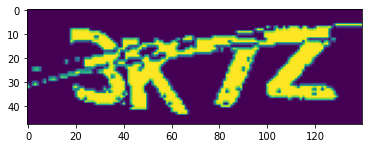

In [11]:
plt.imshow(train_x[11])
plt.show()

In [12]:
print(train_y[11])
print(train_y[11].shape)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(4, 19)


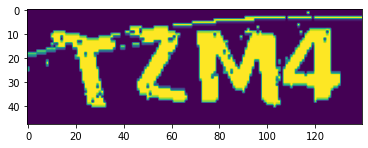

In [13]:
plt.imshow(test_x[10])
plt.show()

In [14]:
print(test_y[10])
print(test_y[10].shape)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(4, 19)


# build model

In [15]:
model = u.build_model()
model.summary()

Model: "THSR_Captcha_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 48, 140)]    0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 48, 140, 1)   0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 46, 138, 64)  640         reshape[0][0]                    
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 46, 138, 64)  256         conv1[0][0]                      
_________________________________________________________________________________

# 類神經網路模型架構可視化 [bug在2.3.0不會出現](https://reurl.cc/3L3W8X) 

In [16]:
model._layers = [layer for layer in model.layers if not isinstance(layer, dict)]  # To avoid bug!!!
tf.keras.utils.plot_model(model, to_file='network_architecture.png', show_shapes=True, dpi=500)
Image('network_architecture.png')

# set callback in training step

In [17]:
# Create a callback for tensorboard
logdir = path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Create a callback that saves the model's weights every 5 epochs
# save_freq 隨蒐集的training data量所決定: 12000*(1-0.2)*(1-0.1)/32=270
ckpt_path = "ckpt_file/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path,
                          verbose=1,
                          save_weights_only=True,
                          save_freq=270*5)  # 1 epoch = 270 batches

# Save the weights using the 'ckpt_path' format
model.save_weights(ckpt_path.format(epoch=0))                    

# fit model with training data

In [18]:
with tf.device('/device:GPU:0'):  # 使用GPU進行訓練
    history = model.fit(x=train_x, y=train_y,
               callbacks=[tensorboard_callback, cp_callback],
               validation_split=arg.validation_rate, batch_size=arg.batch_size, epochs=arg.epochs, verbose=2)
model.metrics_names

Epoch 1/100
270/270 - 8s - loss: 14.9786 - categorical_accuracy: 0.4015 - all_digits_acc: 318.0000 - val_loss: 2.2588 - val_categorical_accuracy: 0.8003 - val_all_digits_acc: 398.0000
Epoch 2/100
270/270 - 7s - loss: 4.6604 - categorical_accuracy: 0.6940 - all_digits_acc: 1994.0000 - val_loss: 0.8429 - val_categorical_accuracy: 0.9008 - val_all_digits_acc: 640.0000
Epoch 3/100
270/270 - 7s - loss: 2.3820 - categorical_accuracy: 0.8017 - all_digits_acc: 3571.0000 - val_loss: 0.4887 - val_categorical_accuracy: 0.9326 - val_all_digits_acc: 730.0000
Epoch 4/100
270/270 - 7s - loss: 1.4509 - categorical_accuracy: 0.8561 - all_digits_acc: 4629.0000 - val_loss: 0.3998 - val_categorical_accuracy: 0.9482 - val_all_digits_acc: 778.0000
Epoch 5/100

Epoch 00005: saving model to ckpt_file/cp-0005.ckpt
270/270 - 7s - loss: 1.0361 - categorical_accuracy: 0.8843 - all_digits_acc: 5256.0000 - val_loss: 0.2551 - val_categorical_accuracy: 0.9581 - val_all_digits_acc: 816.0000
Epoch 6/100
270/270 - 7s - 

['loss', 'categorical_accuracy', 'all_digits_acc']

# evaluate with testing data

In [19]:
model.evaluate(x=test_x, y=test_y, batch_size=len(test_x), verbose=2)
model.metrics_names
# len(test_x)=12000*0.2=2400
# len(validate_x)=12000*(1-0.2)*0.1=960

1/1 - 0s - loss: 0.0368 - categorical_accuracy: 0.9912 - all_digits_acc: 2320.0000


['loss', 'categorical_accuracy', 'all_digits_acc']

# confusion_matrix of each digit

In [20]:
cm_fig = u.plot_confusion_matrix(estimator=model, x=test_x, y_true=test_y)
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=500, bbox_inches='tight')
plt.show()

# to view the process of training step with tensorboard 

In [21]:
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

# save model to predict with new data in the future 
# .h5 是輕量的模型儲存方式視需求而定用何種方式儲存模型
# [參考資料1](https://www.tensorflow.org/guide/keras/save_and_serialize)
#[參考資料2](https://medium.com/@shihaoticking/%E6%B7%B1%E5%85%A5%E8%A7%A3%E6%9E%90-tensorflow-2-0-%E5%84%B2%E5%AD%98%E8%88%87%E8%BC%89%E5%85%A5%E6%A8%A1%E5%9E%8B%E7%9A%84%E5%90%84%E7%A8%AE%E6%96%B9%E6%B3%95-274ea83b99b9)
# [參考資料3](https://reurl.cc/LdWOVK)


In [22]:
! mkdir -p saved_model
model.save('saved_model/thsr_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/thsr_model/assets


# zip folders prepare for download from colab

In [23]:
! zip -r model_logs.zip ./saved_model ./logs # 把兩資料夾加入model_logs.zip

  adding: saved_model/ (stored 0%)
  adding: saved_model/thsr_model/ (stored 0%)
  adding: saved_model/thsr_model/saved_model.pb (deflated 91%)
  adding: saved_model/thsr_model/variables/ (stored 0%)
  adding: saved_model/thsr_model/variables/variables.data-00001-of-00002 (deflated 7%)
  adding: saved_model/thsr_model/variables/variables.index (deflated 72%)
  adding: saved_model/thsr_model/variables/variables.data-00000-of-00002 (deflated 82%)
  adding: saved_model/thsr_model/assets/ (stored 0%)
  adding: logs/ (stored 0%)
  adding: logs/20210329-182430/ (stored 0%)
  adding: logs/20210329-182430/validation/ (stored 0%)
  adding: logs/20210329-182430/validation/events.out.tfevents.1617042284.d81242b4bb76.174.4182.v2 (deflated 73%)
  adding: logs/20210329-182430/train/ (stored 0%)
  adding: logs/20210329-182430/train/events.out.tfevents.1617042270.d81242b4bb76.174.646.v2 (deflated 83%)
  adding: logs/20210329-182430/train/events.out.tfevents.1617042277.d81242b4bb76.profile-empty (defla

# reload model from saved_model

In [24]:
reconstructed_model = tf.keras.models.load_model('./saved_model/thsr_model', custom_objects={'AllDigitsAccuracy': AllDigitsAccuracy})
reconstructed_model.summary()

Model: "THSR_Captcha_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 48, 140)]    0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 48, 140, 1)   0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 46, 138, 64)  640         reshape[0][0]                    
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 46, 138, 64)  256         conv1[0][0]                      
_________________________________________________________________________________

In [25]:
# predict
# load target captcha image ---> image preprocessing ---> feed in model ---> make prediction
prediction = u.test_predict(img_path='/content/THSR_captcha/7473.jpg', 
               classifier=reconstructed_model)
print('prediction: {}'.format(prediction) )

prediction: 74P5


In [27]:
# load from ckpt
model.load_weights('/content/ckpt_file/cp-0090.ckpt')
model.evaluate(x=test_x, y=test_y, batch_size=len(test_x), verbose=2)
model.metrics_names

1/1 - 0s - loss: 0.0350 - categorical_accuracy: 0.9907 - all_digits_acc: 2313.0000


['loss', 'categorical_accuracy', 'all_digits_acc']